In [54]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = '/Stanford CS231n/assignments/assignment1'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Stanford CS231n/assignments/assignment1/cs231n/datasets
/content/drive/My Drive/Stanford CS231n/assignments/assignment1


# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [55]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CIFAR-10 Data Loading and Preprocessing

In [56]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


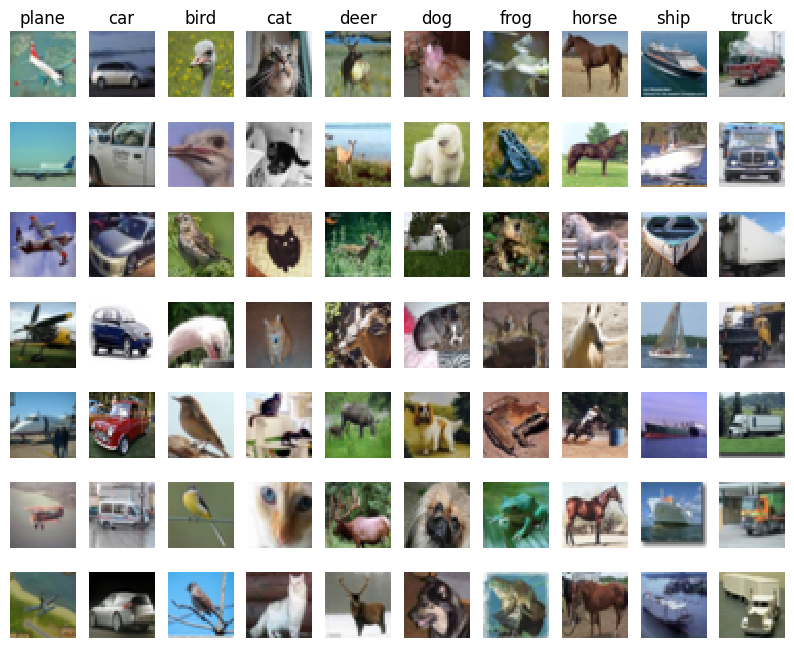

In [57]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [58]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [59]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


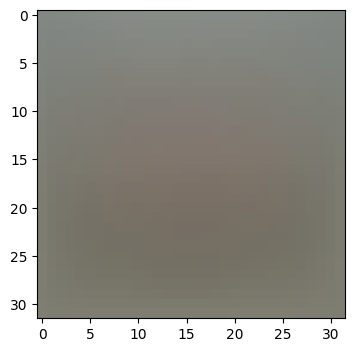

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [60]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

Your code for this section will all be written inside `cs231n/classifiers/linear_svm.py`.

As you can see, we have prefilled the function `svm_loss_naive` which uses for loops to evaluate the multiclass SVM loss function.

In [61]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.003796


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [62]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -13.679762 analytic: -13.679762, relative error: 2.413823e-11
numerical: 20.879246 analytic: 20.879246, relative error: 5.134095e-12
numerical: -15.699384 analytic: -15.699384, relative error: 1.827072e-11
numerical: 6.770165 analytic: 6.770165, relative error: 2.027903e-11
numerical: -20.898629 analytic: -20.898629, relative error: 6.986300e-12
numerical: -18.129265 analytic: -18.129265, relative error: 6.180170e-12
numerical: 6.406555 analytic: 6.406555, relative error: 4.339393e-11
numerical: -24.662169 analytic: -24.662169, relative error: 1.855280e-11
numerical: 8.244771 analytic: 8.244771, relative error: 9.672419e-12
numerical: -50.553472 analytic: -50.553472, relative error: 5.358150e-12
numerical: -29.694495 analytic: -29.694495, relative error: 5.475842e-12
numerical: -13.117312 analytic: -13.117312, relative error: 4.190366e-11
numerical: -30.732858 analytic: -30.732858, relative error: 2.681570e-12
numerical: -4.187127 analytic: -4.187127, relative error: 2.05725

**Inline Question 1**

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

$\color{blue}{\textit Your Answer:}$

**Cause**

For a particular image $x_i\in\mathbb{R}^D$, we are using the following multi-class SVM loss function:
$$\mathcal{L}_i = \sum_{j\in\mathcal{C}\\j\neq y_i}\mathcal{L}_{ij} = \sum_{j\in\mathcal{C}\\j\neq y_i}\max(0, s_j - s_{y_i} + \Delta),$$
where $\mathcal{C}$ is the set of classes, $s_{y_i}$, $s_{j} \in \mathbb{R}$ are the scores given by the correct class $y_i$ and class $j$, respectively, and $\Delta \in\mathbb{R}, \Delta > 0$ is the classification margin. In particular, we are considering linear score functions, $s_j = w_j^Tx_i$, with $w_j\in\mathbb{R}^D$. We can thus rewrite the loss associated with class $j$ as
$$\mathcal{L}_{ij} = \max(0, w_j^Tx_i - w_{y_i}^Tx_i + \Delta).$$

The analytical gradient for $\mathcal{L}_{ij}$ with respect to $w_j$ is given by
$$
\nabla_{w_j}\mathcal{L}_{ij} = \left[\frac{\partial\mathcal{L}_{ij}}{\partial w_{j1}}, \frac{\partial\mathcal{L}_{ij}}{\partial w_{j2}}, \dots \frac{\partial\mathcal{L}_{ij}}{\partial w_{jD}}\right],
$$
where $w_{jk}$, $k\in\{1,\dots,D\}$ is the $k$th component of $w_j$. For each derivative, we have,
$$\frac{\partial\mathcal{L}_{ij}}{\partial w_{jk}}=\begin{cases}0 \quad &\text{if }w_j^Tx_i - w_{y_i}^Tx_i + \Delta < 0\\
x_{ik} \quad &\text{if }w_j^Tx_i - w_{y_i}^Tx_i + \Delta > 0
\end{cases}$$
Because of the $\max$ operator, the loss is not differentiable at $s_{j}=s_{y_i}-\Delta$.

To calculate the centered numerical gradient, we approximate each component $\partial\mathcal{L}_{ij}/\partial w_{jk}$ by
$$
\frac{d\mathcal{L}_{ij}}{dw_{jk}} \approx \frac{\mathcal{L}_{ij}(w_{jk}+h)-\mathcal{L}_{ij}(w_{jk}-h)}{2h},
$$
for $h>0$ small. When evaluating this numerical gradient in the vicinity of a kink, it may happen that
$\mathcal{L}_{ij}(w_j+h) > 0$
and
$\mathcal{L}_{ij}(w_j-h) < 0$
cross over the kink, thus producing a discrepancy with respect to the analytic gradient that will give render a nonnegligible error.

**Concerns**

The evaluation of the numerical gradient nearby kinks of $\mathcal{L}$ can produce significant errors when compared to the inherent (small) errors given by a numerical approximation. These discrepancies with the analytical gradient, in turn, can result to inaccurate and unexpected updates to the weights used in the score functions.

However, we can know if a kink was crossed in the evaluation of the loss function by keeping track of which argument is the output of each $\max$ function in the loss. Therefore, we will know in advance if a kink was crossed and expect an error in the numerical gradient.




In [63]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.003796e+00 computed in 0.107264s
Vectorized loss: 9.003796e+00 computed in 0.024976s
difference: -0.000000


In [64]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.111172s
Vectorized loss and gradient: computed in 0.024586s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss. Your code for this part will be written inside `cs231n/classifiers/linear_classifier.py`.

In [65]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 787.838397
iteration 100 / 1500: loss 288.490757
iteration 200 / 1500: loss 108.237402
iteration 300 / 1500: loss 42.599857
iteration 400 / 1500: loss 18.891581
iteration 500 / 1500: loss 10.000265
iteration 600 / 1500: loss 7.262567
iteration 700 / 1500: loss 6.163131
iteration 800 / 1500: loss 5.309487
iteration 900 / 1500: loss 5.639007
iteration 1000 / 1500: loss 5.549522
iteration 1100 / 1500: loss 5.601353
iteration 1200 / 1500: loss 5.423378
iteration 1300 / 1500: loss 5.711725
iteration 1400 / 1500: loss 5.104690
That took 15.181670s


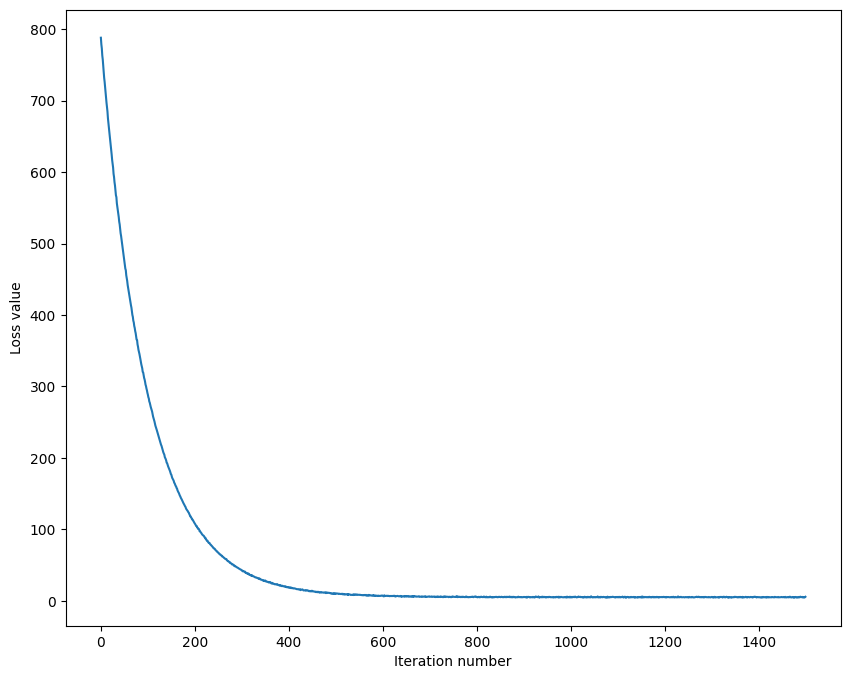

In [66]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [67]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.370469
validation accuracy: 0.380000


In [68]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.39 (> 0.385) on the validation set.

# Note: you may see runtime/overflow warnings during hyper-parameter search.
# This may be caused by extreme values, and is not a bug.

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

learning_rates = np.geomspace(2e-7, 4e-7, 7)
regularization_strengths = np.geomspace(5e3, 5e4, 5)

for lr in learning_rates:
  for rs in regularization_strengths:
    print("Learning rate: %.2E Regularization strength: %.2E" % (lr, rs))
    svm = LinearSVM()
    # training
    svm.train(X_train, y_train, lr, rs, num_iters=1500, verbose=True)
    # evaluation
    y_train_pred = svm.predict(X_train)
    train_accuracy = np.mean(y_train == y_train_pred)
    y_val_pred = svm.predict(X_val)
    val_accuracy = np.mean(y_val == y_val_pred)
    results[(lr, rs)] = (train_accuracy, val_accuracy)
    if val_accuracy > best_val:
      best_val = val_accuracy
      best_svm = svm

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

Learning rate: 2.00E-07 Regularization strength: 5.00E+03
iteration 0 / 1500: loss 172.306787
iteration 100 / 1500: loss 109.711218
iteration 200 / 1500: loss 73.587256
iteration 300 / 1500: loss 50.099959
iteration 400 / 1500: loss 34.716002
iteration 500 / 1500: loss 24.772500
iteration 600 / 1500: loss 17.469368
iteration 700 / 1500: loss 13.864886
iteration 800 / 1500: loss 10.479421
iteration 900 / 1500: loss 8.758227
iteration 1000 / 1500: loss 7.615964
iteration 1100 / 1500: loss 6.079715
iteration 1200 / 1500: loss 5.928285
iteration 1300 / 1500: loss 5.703829
iteration 1400 / 1500: loss 5.525765
Learning rate: 2.00E-07 Regularization strength: 8.89E+03
iteration 0 / 1500: loss 291.683292
iteration 100 / 1500: loss 139.017366
iteration 200 / 1500: loss 69.503298
iteration 300 / 1500: loss 36.373519
iteration 400 / 1500: loss 20.195117
iteration 500 / 1500: loss 11.832916
iteration 600 / 1500: loss 8.207369
iteration 700 / 1500: loss 6.395843
iteration 800 / 1500: loss 6.066269


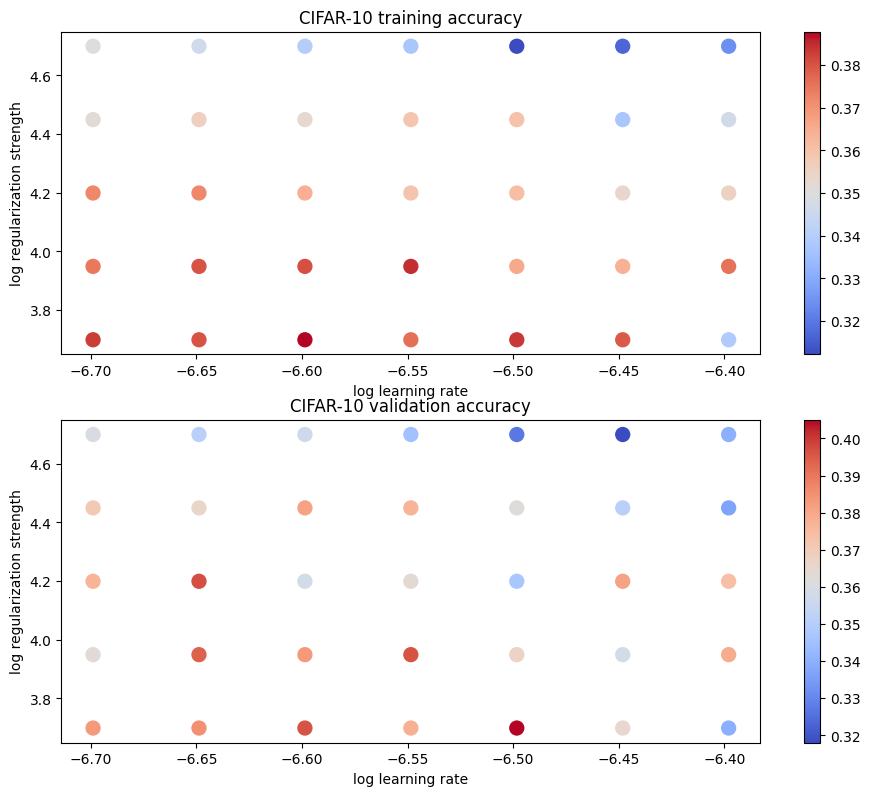

In [69]:
# Visualize the cross-validation results
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [70]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.369000


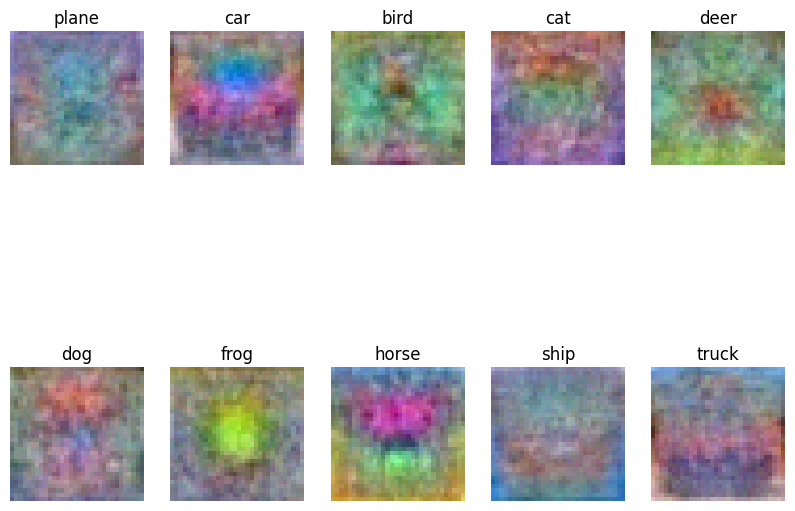

In [71]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 2**

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look the way they do.

$\color{blue}{\textit Your Answer:}$

The SVM weights are obtained by performing a combination of the images belonging to each class. In turn, visualizing the SVM weights gives, for each class, a generalization of the distinctive features of the images that serves as a template for classification.

In the visualization of each class we can observe the distinctive colors and shapes that characterize the class, which tend to be located towards the center of the image. For example, the dog visualization is brown and we can distinguish the shape of the head in the upper middle center region of the image. The frog, in turn, presents a bright green region right in the middle. The ship has a brown and grey geometric shape occupying the center of the image, with blue color all around that undoubtedly represents the sea. The horse has a distinctive brown shiny shape in the middle of the picture, with two heads (one looking left and one right) that stem from learning from pictures where horses can look in either direction.